In [1]:
import pandas as pd
from scipy.stats import shapiro, ttest_1samp, levene
import scipy.stats as stats
import pingouin as pg
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
data_path = '/hdd/data/adp_data/student_lifestyle_dataset.csv'

df = pd.read_csv(data_path, index_col = 'Student_ID')
df.head()

,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,Stress_Level,Gender,Grades
Student_ID,,,,,,,,
1,6.9,3.8,8.7,2.8,1.8,Moderate,Male,7.48
2,5.3,3.5,8.0,4.2,3.0,Low,Female,6.88
3,5.1,3.9,9.2,1.2,4.6,Low,Male,6.68
4,6.5,2.1,7.2,1.7,6.5,Moderate,Male,7.20
5,8.1,0.6,6.5,2.2,6.6,High,Male,8.78


H_0: 학생들의 평균 수면 시간 = 9  
H_1: 학생들의 평균 수면 시간 < 9

In [3]:
sampled_df = df.sample(30, random_state = 526)

In [4]:
stat, p = shapiro(sampled_df['Sleep_Hours_Per_Day'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=0.939, p=0.084


In [5]:
t_stat, p_two_tailed = ttest_1samp(df['Sleep_Hours_Per_Day'], 9)

# Left-tailed test
if t_stat < 0:
    p_one_tailed = p_two_tailed / 2
else:
    p_one_tailed = 1 - (p_two_tailed / 2)


print('t-statistic=%.3f, one-tailed p=%.3f' % (t_stat, p_one_tailed))

t-statistic=-45.879, one-tailed p=0.000


유의수준 0.05에서 단측 t-검정을 실시한 결과, p-value가 0.000 < 0.05로 유의수준보다 작으므로, 귀무가설을 기각한다.  
따라서, 학생들의 하루 평균 수면 시간은 9시간보다 유의미하게 적다고 결론지을 수 있다.

귀무가설(H₀): 성별에 따라 스트레스 수준의 분포는 동일하다.  
대립가설(H₁): 성별에 따라 스트레스 수준의 분포는 다르다.

In [6]:
contingency = pd.crosstab(df['Gender'], df['Stress_Level'])
print(contingency)

Stress_Level  High  Low  Moderate
Gender                           
Female         497  150       337
Male           532  147       337


In [7]:
chi2, p, dof, expected = stats.chi2_contingency(contingency)

print('Chi2=%.3f, p=%.3f, dof=%.3f' % (chi2, p, dof))
print('Expected Frequencies:')
print(expected)

Chi2=0.709, p=0.702, dof=2.000
Expected Frequencies:
[[506.268 146.124 331.608]
 [522.732 150.876 342.392]]


유의수준 0.05에서 동질성 검정을 실시한 결과, p-value가 0.702 > 0.05로 유의수준보다 크므로, 귀무가설을 채택한다.  
따라서, 성별에 따라 스트레스 수준의 분포는 동일하다고 할 수 있다.

H_0: 스트레스 수준(Stress_Level)에 따라 학생들의 성적(Grades)에 차이가 없다.  
H_1: 스트레스 수준(Stress_Level)에 따라 학생들의 성적(Grades)에 차이가 있다.

In [8]:
low_stress = df[df['Stress_Level'] == 'Low']['Grades']
moderate_stress = df[df['Stress_Level'] == 'Moderate']['Grades']
high_stress = df[df['Stress_Level'] == 'High']['Grades']

print('Low stress group normality test:', end = ' ')
stat, p = shapiro(low_stress)
print('Statistics=%.3f, p=%.3f' % (stat, p))
print('Moderate stress group normality test:', end = ' ')
stat, p = shapiro(moderate_stress)
print('Statistics=%.3f, p=%.3f' % (stat, p))
print('High stress group normality test:', end = ' ')
stat, p = shapiro(high_stress)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Low stress group normality test: Statistics=0.996, p=0.551
Moderate stress group normality test: Statistics=0.996, p=0.089
High stress group normality test: Statistics=0.994, p=0.000


High 그룹은 정규성을 만족하지 않지만 데이터가 많으므로 비모수적 검정 진행하지 않음.

In [9]:
stat, p = levene(low_stress, moderate_stress, high_stress)
print('Levene’s test for equal variances: Statistics=%.3f, p=%.3f' % (stat, p))

Levene’s test for equal variances: Statistics=21.382, p=0.000


In [10]:
welch_result = pg.welch_anova(data = df, dv = 'Grades', between = 'Stress_Level')
print(welch_result)

         Source  ddof1      ddof2           F          p-unc       np2
0  Stress_Level      2  863.31587  467.367018  2.883775e-138  0.303307


유의수준 0.05에서 일원분산분석을 실시한 결과, p-value가 2.883775e-138 < 0.05로 유의수준보다 작으므로, 귀무가설을 기각한다.  
즉, 스트레스 수준에 따라 통계적으로 성적에 차이가 있다고 할 수 있다.

In [11]:
post_hoc_result = pg.pairwise_gameshowell(data = df, dv = 'Grades', between = 'Stress_Level')
print(post_hoc_result)

      A         B   mean(A)   mean(B)      diff        se          T  \
0  High       Low  8.154840  7.042088  1.112752  0.037901  29.359484   
1  High  Moderate  8.154840  7.562047  0.592792  0.030182  19.640702   
2   Low  Moderate  7.042088  7.562047 -0.519960  0.037798 -13.756449   

            df  pval    hedges  
0   601.477467   0.0  1.692226  
1  1632.646346   0.0  0.929814  
2   578.468027   0.0 -0.948535  


High 그룹은 Low / Moderate 그룹보다 성적이 우수하며, Moderate 그룹도 Low 그룹보다 성적이 높음.

In [12]:
encoded_df = pd.get_dummies(df, columns = ['Gender', 'Stress_Level'], drop_first = True)
encoded_df = encoded_df.replace({True: 1, False: 0})
encoded_df.head()

/tmp/ipykernel_2009541/2981149082.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  encoded_df = encoded_df.replace({True: 1, False: 0})


,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,Grades,Gender_Male,Stress_Level_Low,Stress_Level_Moderate
Student_ID,,,,,,,,,
1,6.9,3.8,8.7,2.8,1.8,7.48,1,0,1
2,5.3,3.5,8.0,4.2,3.0,6.88,0,1,0
3,5.1,3.9,9.2,1.2,4.6,6.68,1,1,0
4,6.5,2.1,7.2,1.7,6.5,7.20,1,0,1
5,8.1,0.6,6.5,2.2,6.6,8.78,1,0,0


In [13]:
stat, p = shapiro(encoded_df['Grades'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=0.997, p=0.003


데이터가 많아서 p-value가 작게 나온 것같음. 히스토그램을 확인했을 때 정규분포 모양이었으므로 Q-Q plot 확인

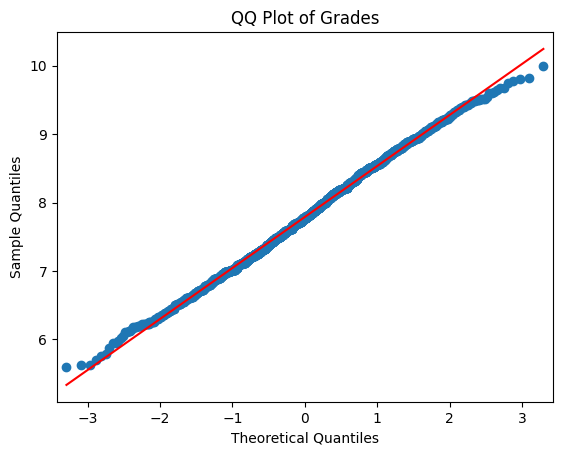

In [14]:
sm.qqplot(encoded_df['Grades'], line = 's')
plt.title('QQ Plot of Grades')
plt.show()

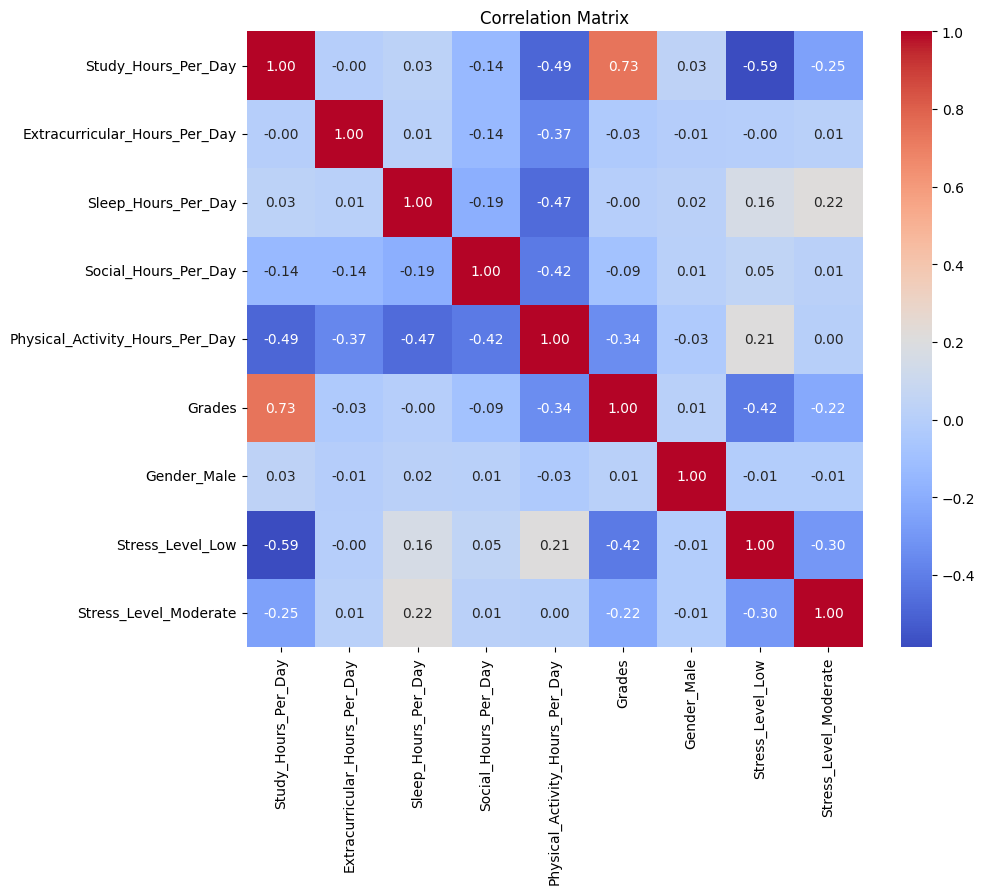

In [15]:
corr_matrix = encoded_df.corr()

plt.figure(figsize = (10, 8))
sns.heatmap(corr_matrix, annot = True, fmt = '.2f', cmap = 'coolwarm', square = True)
plt.title('Correlation Matrix')
plt.show()

In [16]:
vif = pd.DataFrame()
vif['Variable'] = encoded_df.drop(columns = ['Grades']).columns
vif['VIF'] = [
    variance_inflation_factor(encoded_df.drop(columns = ['Grades']).values, i) for i in range(encoded_df.drop(columns = ['Grades']).shape[1])
]
print(vif)

                          Variable        VIF
0              Study_Hours_Per_Day  42.903516
1    Extracurricular_Hours_Per_Day   4.108792
2              Sleep_Hours_Per_Day  37.474106
3             Social_Hours_Per_Day   3.748046
4  Physical_Activity_Hours_Per_Day   4.242466
5                      Gender_Male   1.001969
6                 Stress_Level_Low   2.802780
7            Stress_Level_Moderate   1.977313


In [17]:
def stepwise_selection(X, y,
                       initial_list = [],
                       thereshold_in = 0.05,
                       thereshold_out = 0.05,
                       verbose = True):
    
    included = list(initial_list)
    while True:
        changed = False

        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index = excluded, dtype = float)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(X[included + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < thereshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
        
        # backward step
        model = sm.OLS(y, sm.add_constant(X[included])).fit()
        # use all coefs except intercept
        pvals = model.pvalues.iloc[1:]
        worst_pval = pvals.max()
        if worst_pval > thereshold_out:
            changed = True
            worst_feature = pvals.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        
        if not changed:
            break
    
    return included

In [18]:
X = encoded_df.drop(columns = ['Grades'])
y = encoded_df['Grades']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 526)

selected_features = stepwise_selection(X_train, y_train)

X_train_selected = sm.add_constant(X_train[selected_features])
X_test_selected = sm.add_constant(X_test[selected_features])

final_model = sm.OLS(y_train, X_train_selected).fit()
print(final_model.summary())

y_pred = final_model.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'\n Test MSE: {mse:.3f}')
print(f' Test R2: {r2:.3f}')

Add  Study_Hours_Per_Day            with p-value 4.02846e-269
Add  Stress_Level_Moderate          with p-value 0.0113022
Add  Extracurricular_Hours_Per_Day  with p-value 0.0185493
                            OLS Regression Results                            
Dep. Variable:                 Grades   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     624.4
Date:                Wed, 23 Apr 2025   Prob (F-statistic):          1.89e-268
Time:                        14:05:14   Log-Likelihood:                -1193.1
No. Observations:                1600   AIC:                             2394.
Df Residuals:                    1596   BIC:                             2416.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              

In [19]:
X = encoded_df.drop(columns = ['Grades'])
y = encoded_df['Grades']

X['Study_x_Stress_Moderate'] = X['Study_Hours_Per_Day'] * X['Stress_Level_Moderate']
X['Study_x_Stress_Low'] = X['Study_Hours_Per_Day'] * X['Stress_Level_Low']
X['Study_x_Activity'] = X['Study_Hours_Per_Day'] * X['Physical_Activity_Hours_Per_Day']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 526)

selected_features = stepwise_selection(X_train, y_train)
model = sm.OLS(y_train, sm.add_constant(X_train[selected_features])).fit()
print(model.summary())

Add  Study_Hours_Per_Day            with p-value 4.02846e-269
Add  Stress_Level_Moderate          with p-value 0.0113022
Add  Extracurricular_Hours_Per_Day  with p-value 0.0185493
                            OLS Regression Results                            
Dep. Variable:                 Grades   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     624.4
Date:                Wed, 23 Apr 2025   Prob (F-statistic):          1.89e-268
Time:                        14:08:22   Log-Likelihood:                -1193.1
No. Observations:                1600   AIC:                             2394.
Df Residuals:                    1596   BIC:                             2416.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              

In [20]:
y_pred = model.predict(sm.add_constant(X_test[selected_features]))
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'\n Test MSE: {mse:.3f}')
print(f' Test R2: {r2:.3f}')


 Test MSE: 0.239
 Test R2: 0.540
